#                          REAL-TIME FORECAST
##              Predicting Hourly Electricity Consumption

## LIBRARIES

In [1]:
import numpy
import pandas as pd
import datetime as dt
import urllib
import json
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.
/home/yashshah/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yashshah/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yashshah/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yashshah/.local/lib/python3.6/site-packages/tensorflo

## DATA EXTRACTION

### Fetching Past Electricity Consumption Data for the US city : Homestead(HST)

In [2]:
key = 'dd77e4c78c49c7b78faa3d08a9f429ee' # API Key

# URL url_string to access the data
url_string = 'https://api.eia.gov/series/?api_key=%s&series_id=EBA.HST-ALL.D.H'%key

# Open the URL url_string, which is a string.
url = urllib.request.urlopen(url_string)

# Reading JSON File from url
data = json.loads(url.read().decode())

# Accessing data of hourly consumption of Electricity 
data = data['series'][0]['data']

### Preparing Pandas DataFrame with two columns as Date and Consumption

In [3]:
# Initialising Dataframe having columns as Date and Consumption
DataFrame_data = pd.DataFrame(columns=['Date','Consumption'])
DataFrame_data['Consumption'] = DataFrame_data['Consumption'].astype(float)

### Adding List of two elements(Date,Consumption) to pandas dataframe

In [4]:
# data is a list of lists in which each list contain two elements [date and time,consumption of electricity]
for em in data:

    TimeStamp_String = em[0]
    Consumption_val  = em[1]
    
    # Consumption can't be null
    if(Consumption_val != None):
        # Consumption to floating-point numbers which is useful in further analysis
        consumption = float(int(Consumption_val)*1.00)
        # Adding data_row to dataframe
        data_row = [TimeStamp_String,consumption]
        DataFrame_data.loc[-1,:] = data_row
        DataFrame_data.index += 1

In [5]:
DataFrame_data.head()

,Date,Consumption
43683,20200827T04Z,80.0
43682,20200827T03Z,87.0
43681,20200827T02Z,95.0
43680,20200827T01Z,103.0
43679,20200827T00Z,104.0


### Analysing Consumption Pattern with Time  

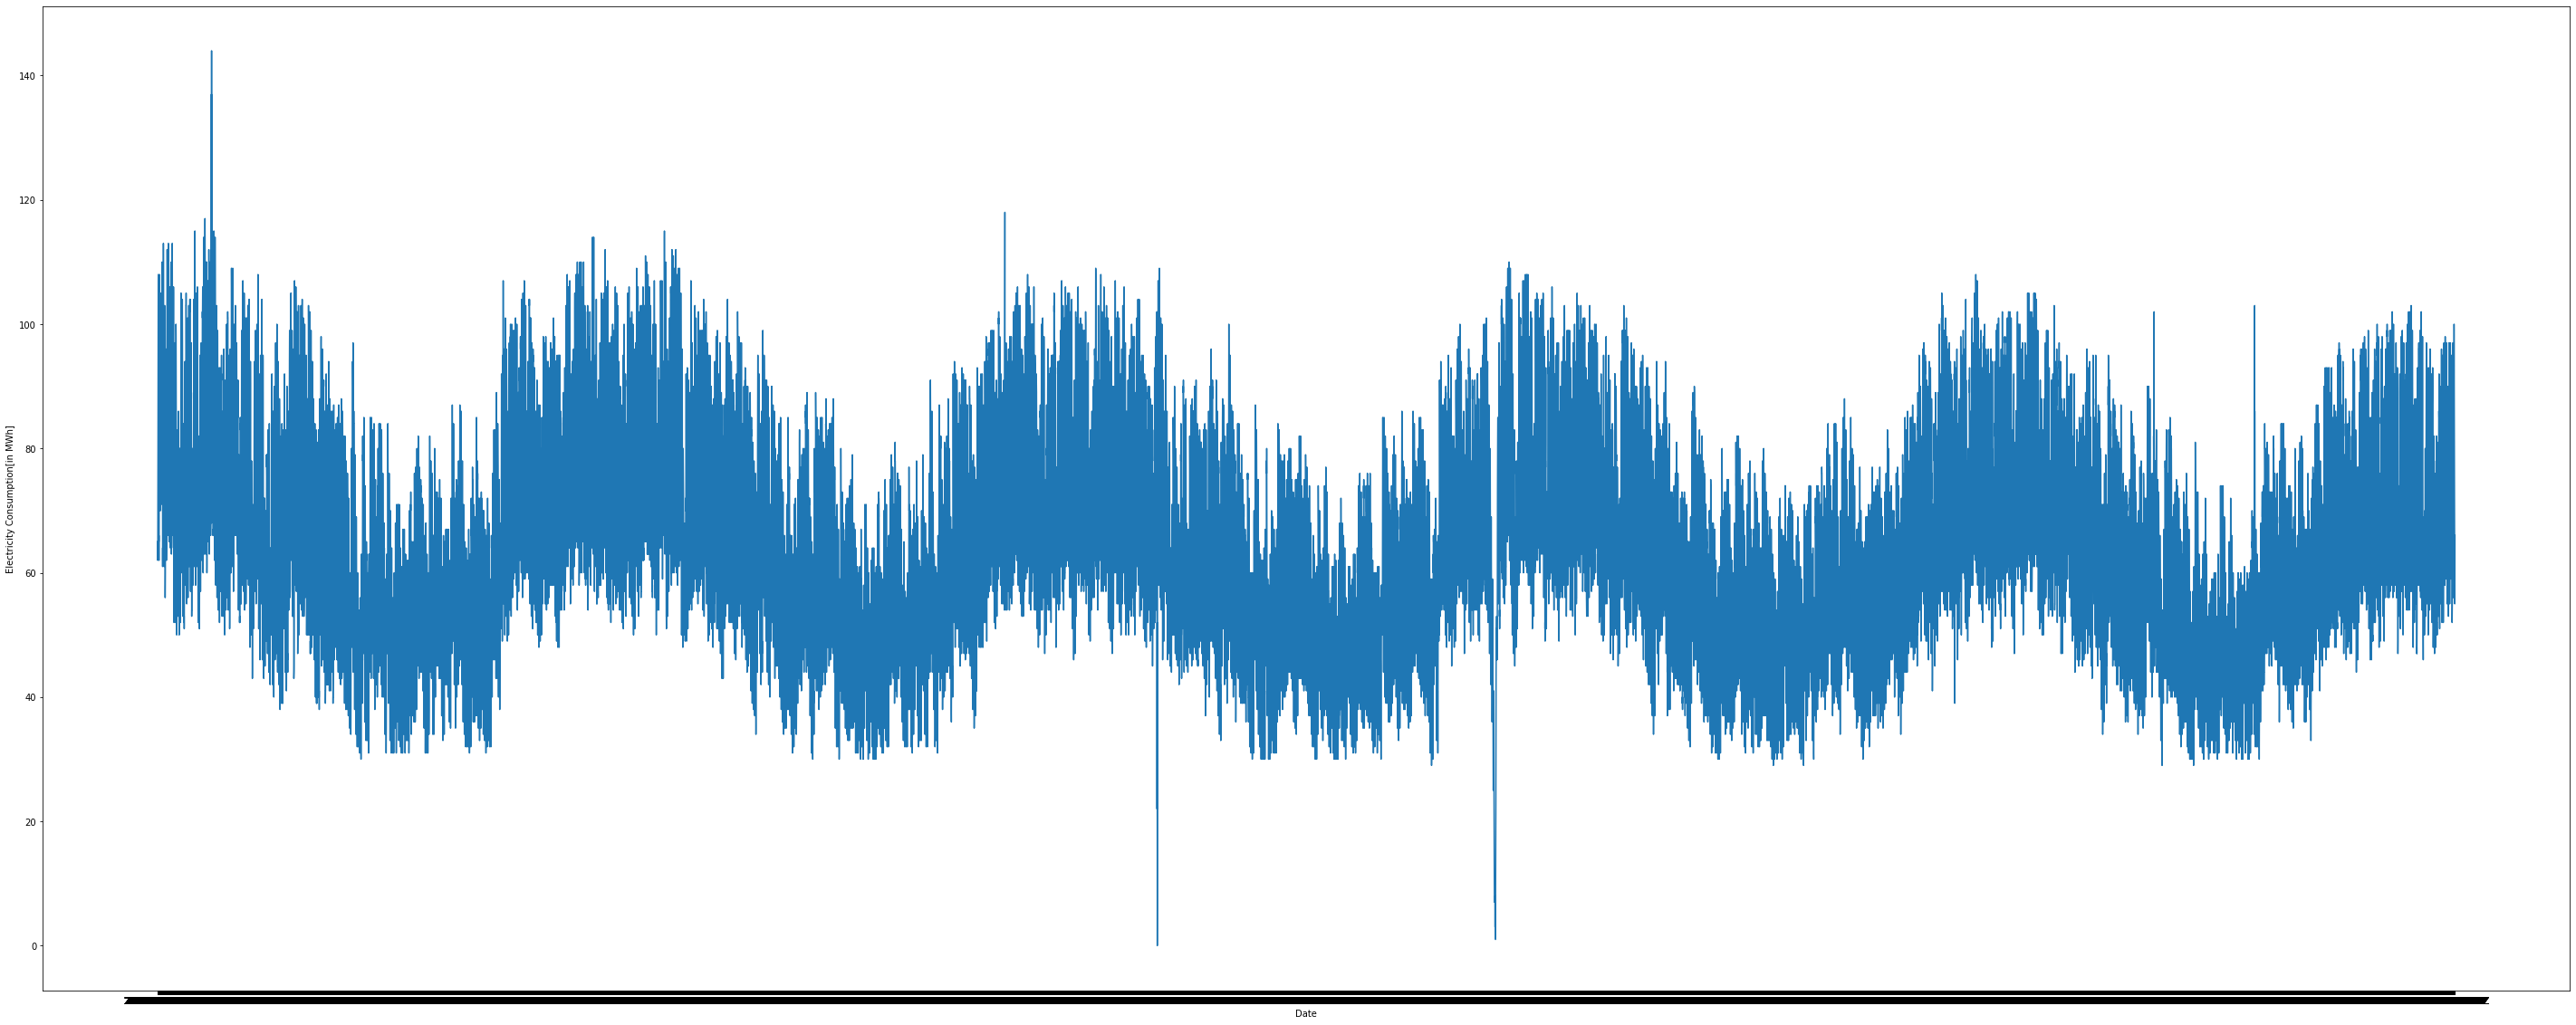

In [10]:
fig,ax = plt.subplots(figsize = (50,20))                       # Create a figure and a set of subplots.
plt.ylabel('Electricity Consumption[in MWh]') # labelling Y-axis
plt.xlabel('Date')                            # labelling X-axis
ax.plot(DataFrame_data['Date'],DataFrame_data['Consumption'])
plt.show()

### Fething Historical Weather Data using WorldWeatherOnline API

In [6]:
# Installing WorldWeatherOnline weather data API wrapper
!pip3 install wwo-hist

  Using cached https://files.pythonhosted.org/packages/5a/b4/19a4d6a0d131567cf4b2ffa3758710d867f7d7d3f0c6f94bd63fadf1d02a/wwo_hist-0.0.5-py3-none-any.whl


In [7]:
# Import Package 
from wwo_hist import retrieve_hist_data

In [9]:
# Retrieving data until today from 11 dec 2017
frequency=1
start_date = '11-DEC-2017'
today_date = dt.date.today()
end_date = today_date
api_key = 'a272d49bf37c42508c982909200407'
location_list = ['Homestead']

hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = True,
                                export_csv = False,
                                store_df = True)



Retrieving weather data for Homestead


Currently retrieving data for Homestead: from 2017-12-11 to 2017-12-31
Time elapsed (hh:mm:ss.ms) 0:00:03.672211
Currently retrieving data for Homestead: from 2018-01-01 to 2018-01-31
Time elapsed (hh:mm:ss.ms) 0:00:07.246184
Currently retrieving data for Homestead: from 2018-02-01 to 2018-02-28
Time elapsed (hh:mm:ss.ms) 0:00:10.627578
Currently retrieving data for Homestead: from 2018-03-01 to 2018-03-31
Time elapsed (hh:mm:ss.ms) 0:00:14.258700
Currently retrieving data for Homestead: from 2018-04-01 to 2018-04-30
Time elapsed (hh:mm:ss.ms) 0:00:17.705379
Currently retrieving data for Homestead: from 2018-05-01 to 2018-05-31
Time elapsed (hh:mm:ss.ms) 0:00:21.217766
Currently retrieving data for Homestead: from 2018-06-01 to 2018-06-30
Time elapsed (hh:mm:ss.ms) 0:00:24.648818
Currently retrieving data for Homestead: from 2018-07-01 to 2018-07-31
Time elapsed (hh:mm:ss.ms) 0:00:29.393028
Currently retrieving data for Homestead: from 2018-08-

In [10]:
# dataframe with hourly weather data from WorldWeatherOnline
weather_DataFrame = hist_weather_data[0]
weather_DataFrame.head()

,date_time,Homestead_maxtempC,Homestead_mintempC,Homestead_totalSnow_cm,Homestead_sunHour,Homestead_uvIndex,Homestead_moon_illumination,Homestead_moonrise,Homestead_moonset,Homestead_sunrise,...,Homestead_WindGustKmph,Homestead_cloudcover,Homestead_humidity,Homestead_precipMM,Homestead_pressure,Homestead_tempC,Homestead_visibility,Homestead_winddirDegree,Homestead_windspeedKmph,Homestead_location
0,2017-12-11 00:00:00,19,10,0.0,10.8,4,41,02:04 AM,02:33 PM,07:58 AM,...,30,1,58,0.0,1024,11,10,338,18,Homestead
1,2017-12-11 01:00:00,19,10,0.0,10.8,4,41,02:04 AM,02:33 PM,07:58 AM,...,30,1,58,0.0,1024,11,10,339,18,Homestead
2,2017-12-11 02:00:00,19,10,0.0,10.8,4,41,02:04 AM,02:33 PM,07:58 AM,...,30,0,59,0.0,1024,11,10,341,18,Homestead
3,2017-12-11 03:00:00,19,10,0.0,10.8,4,41,02:04 AM,02:33 PM,07:58 AM,...,31,0,60,0.0,1024,11,10,342,18,Homestead
4,2017-12-11 04:00:00,19,10,0.0,10.8,4,41,02:04 AM,02:33 PM,07:58 AM,...,31,0,57,0.0,1024,11,10,343,19,Homestead


In [11]:
# features in a dataframes of hist_weather_data
print(weather_DataFrame.columns)

Index(['date_time', 'Homestead_maxtempC', 'Homestead_mintempC',
       'Homestead_totalSnow_cm', 'Homestead_sunHour', 'Homestead_uvIndex',
       'Homestead_moon_illumination', 'Homestead_moonrise',
       'Homestead_moonset', 'Homestead_sunrise', 'Homestead_sunset',
       'Homestead_DewPointC', 'Homestead_FeelsLikeC', 'Homestead_HeatIndexC',
       'Homestead_WindChillC', 'Homestead_WindGustKmph',
       'Homestead_cloudcover', 'Homestead_humidity', 'Homestead_precipMM',
       'Homestead_pressure', 'Homestead_tempC', 'Homestead_visibility',
       'Homestead_winddirDegree', 'Homestead_windspeedKmph',
       'Homestead_location'],
      dtype='object')


In [12]:
# features which we are going use
features =['Date', 'Homestead_maxtempC', 'Homestead_mintempC','Homestead_DewPointC',
       'Homestead_FeelsLikeC', 'Homestead_HeatIndexC', 'Homestead_WindChillC',
       'Homestead_WindGustKmph', 'Homestead_cloudcover', 'Homestead_humidity',
       'Homestead_precipMM', 'Homestead_pressure', 'Homestead_tempC',
       'Homestead_visibility', 'Homestead_winddirDegree',
       'Homestead_windspeedKmph']

In [13]:
# Function to convert Timestamp object to String 
def TimestampToString(date):
    return date.strftime("%Y%m%dT%HZ")

In [14]:
# weather_DataFrame to List
weatherList = weather_DataFrame.values.tolist()

In [15]:
weather_rows = []

for row in weatherList:
    
    row_lst = []
    row_lst.append(TimestampToString(row[0]))
    
    for idx in range(1,len(row)):
        if(weather_DataFrame.columns[idx] in features):
            row_lst.append(row[idx])
    
    weather_rows.append(row_lst)

In [16]:
DataFrame_weather = pd.DataFrame(weather_rows, columns = features) 

In [17]:
joinFeatures = ['Date']

In [18]:
DataFrame_merged = pd.merge(DataFrame_data,DataFrame_weather,on = joinFeatures)

In [19]:
DataFrame_merged.shape

(23245, 17)

In [20]:
DataFrame_merged.head()

,Date,Consumption,Homestead_maxtempC,Homestead_mintempC,Homestead_DewPointC,Homestead_FeelsLikeC,Homestead_HeatIndexC,Homestead_WindChillC,Homestead_WindGustKmph,Homestead_cloudcover,Homestead_humidity,Homestead_precipMM,Homestead_pressure,Homestead_tempC,Homestead_visibility,Homestead_winddirDegree,Homestead_windspeedKmph
0,20200827T04Z,80.0,32,27,24,32,32,28,23,77,81,0.2,1015,28,10,97,14
1,20200827T03Z,87.0,32,27,24,32,32,28,24,80,80,0.4,1015,28,10,96,15
2,20200827T02Z,95.0,32,27,24,32,32,28,24,78,79,0.3,1015,28,10,94,15
3,20200827T01Z,103.0,32,27,24,32,32,28,24,76,78,0.0,1015,28,9,91,15
4,20200827T00Z,104.0,32,27,24,33,33,28,24,74,77,0.1,1015,28,9,88,15


In [21]:
def StringToDatetime(date_string):
    date = date_string[:4]+" "+date_string[4:6]+" "+date_string[6:8]+" "+date_string[9:11]
    return dt.datetime.strptime(date,'%Y %m %d %H')

In [22]:
DataFrame = DataFrame_merged.copy()
DataFrame['Date'] = DataFrame.Date.apply(StringToDatetime)

In [23]:
DataFrame.head()

,Date,Consumption,Homestead_maxtempC,Homestead_mintempC,Homestead_DewPointC,Homestead_FeelsLikeC,Homestead_HeatIndexC,Homestead_WindChillC,Homestead_WindGustKmph,Homestead_cloudcover,Homestead_humidity,Homestead_precipMM,Homestead_pressure,Homestead_tempC,Homestead_visibility,Homestead_winddirDegree,Homestead_windspeedKmph
0,2020-08-27 04:00:00,80.0,32,27,24,32,32,28,23,77,81,0.2,1015,28,10,97,14
1,2020-08-27 03:00:00,87.0,32,27,24,32,32,28,24,80,80,0.4,1015,28,10,96,15
2,2020-08-27 02:00:00,95.0,32,27,24,32,32,28,24,78,79,0.3,1015,28,10,94,15
3,2020-08-27 01:00:00,103.0,32,27,24,32,32,28,24,76,78,0.0,1015,28,9,91,15
4,2020-08-27 00:00:00,104.0,32,27,24,33,33,28,24,74,77,0.1,1015,28,9,88,15


## FEATURE SELECTION

Statistical tests can be used to select those features that have the strongest relationship with the output variable.

### Correlation Matrix with Heatmap 

Correlation states how the features are related to each other or the target variable.

Correlation can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable).

Heatmap makes it easy to identify which features are most related to the target variable, we will plot heatmap of correlated features using the seaborn library.

In [24]:
DataFrame_merged.pop('Date')
DataFrame_merged.head()

,Consumption,Homestead_maxtempC,Homestead_mintempC,Homestead_DewPointC,Homestead_FeelsLikeC,Homestead_HeatIndexC,Homestead_WindChillC,Homestead_WindGustKmph,Homestead_cloudcover,Homestead_humidity,Homestead_precipMM,Homestead_pressure,Homestead_tempC,Homestead_visibility,Homestead_winddirDegree,Homestead_windspeedKmph
0,80.0,32,27,24,32,32,28,23,77,81,0.2,1015,28,10,97,14
1,87.0,32,27,24,32,32,28,24,80,80,0.4,1015,28,10,96,15
2,95.0,32,27,24,32,32,28,24,78,79,0.3,1015,28,10,94,15
3,103.0,32,27,24,32,32,28,24,76,78,0.0,1015,28,9,91,15
4,104.0,32,27,24,33,33,28,24,74,77,0.1,1015,28,9,88,15


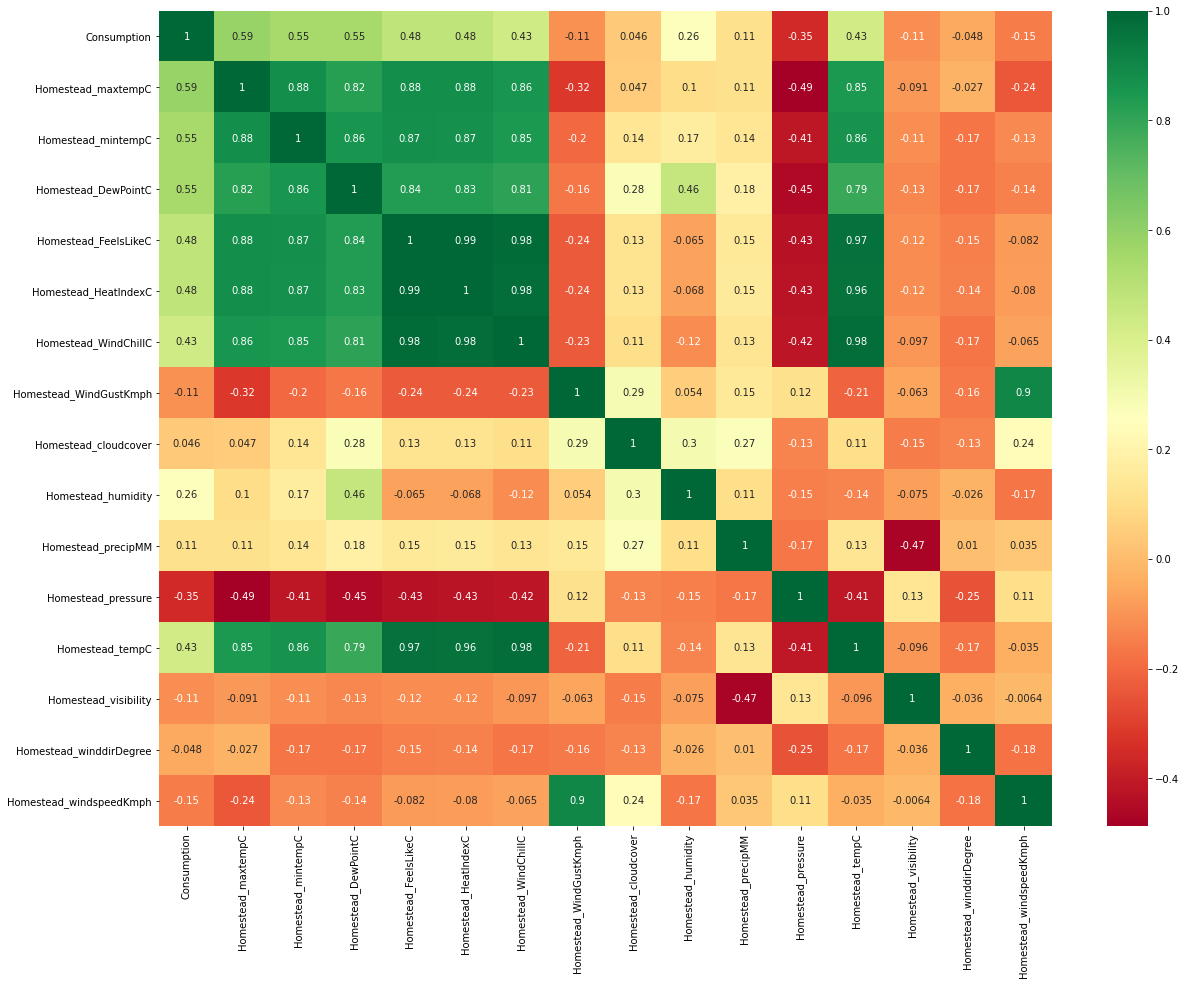

In [25]:
#get correlations of each features in dataset
corrmat = DataFrame_merged.astype(float).corr()
top_corr_features = corrmat.index
plt.figure(figsize = (20,15))
#plot heat map
g=sns.heatmap(DataFrame_merged[top_corr_features].astype(float).corr(),annot=True,cmap="RdYlGn")

### Pearson Correlation Coefficient

A Pearson correlation is a number between -1 and +1 that indicates to which extent 2 variables are linearly related.

A <b>correlation coefficient of 1</b> means that two variables are perfectly positively linearly related.

A <b>correlation of 0</b> means that two variables don't have any linear relation whatsoever.

A <b>correlation of -1</b> indicates that the two variables are perfectly negatively linearly related.

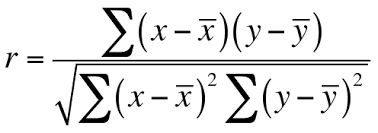

In [26]:
pearsoncorr = DataFrame_merged.astype(float).corr(method='pearson')

In [27]:
pearsoncorr_list = pearsoncorr.values.tolist()
csmpn_list = list(pearsoncorr_list[0])
csmpn_list.pop(0)

features = list(DataFrame_merged.columns)
features.pop(0)

Pearson_frame = pd.DataFrame(columns=['Features','Ratio']) 

print('CONSUMPTION CORRELATIONS (PEARSON) FOR HOMESTEAD')

for index,value in enumerate(csmpn_list):
    Pearson_frame.loc[len(Pearson_frame)] = [features[index],value]

Pearson_frame

CONSUMPTION CORRELATIONS (PEARSON) FOR HOMESTEAD


,Features,Ratio
0,Homestead_maxtempC,0.587078
1,Homestead_mintempC,0.550997
2,Homestead_DewPointC,0.550457
3,Homestead_FeelsLikeC,0.479750
4,Homestead_HeatIndexC,0.482866
5,Homestead_WindChillC,0.434997
6,Homestead_WindGustKmph,-0.107613
7,Homestead_cloudcover,0.046337
8,Homestead_humidity,0.263907
9,Homestead_precipMM,0.112738


# DATA NORMALISATION

The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.

It is required only when features have different ranges.

In [28]:
values_list = DataFrame_merged.values.tolist()

## MinMaxScaler

In this approach, the data is scaled to a fixed range — usually 0 to 1.

The cost of having this bounded range is that we will end up with smaller standard deviations, which can suppress the effect of outliers. Thus MinMax Scalar is sensitive to outliers.

The standardization is given by:

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_scaled = X_std * (max - min) + min

where min, max = feature_range.

In [29]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(values_list)  

In [30]:
dataset.shape

(23245, 16)

# TRAINING and TESTING

In [31]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

15574 7671


In [32]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0:15]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 15])
	return numpy.array(dataX), numpy.array(dataY)

In [33]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [34]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, 15)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)


Epoch 1/100
 - 24s - loss: 0.0063
Epoch 2/100
 - 23s - loss: 0.0035
Epoch 3/100
 - 28s - loss: 0.0032
Epoch 4/100
 - 24s - loss: 0.0031
Epoch 5/100
 - 23s - loss: 0.0030
Epoch 6/100
 - 27s - loss: 0.0029
Epoch 7/100
 - 24s - loss: 0.0028
Epoch 8/100
 - 23s - loss: 0.0027
Epoch 9/100
 - 23s - loss: 0.0027
Epoch 10/100
 - 26s - loss: 0.0026
Epoch 11/100
 - 23s - loss: 0.0026
Epoch 12/100
 - 23s - loss: 0.0026
Epoch 13/100
 - 22s - loss: 0.0026
Epoch 14/100
 - 24s - loss: 0.0026
Epoch 15/100
 - 28s - loss: 0.0026
Epoch 16/100
 - 25s - loss: 0.0026
Epoch 17/100
 - 22s - loss: 0.0025
Epoch 18/100
 - 23s - loss: 0.0025
Epoch 19/100
 - 26s - loss: 0.0025
Epoch 20/100
 - 25s - loss: 0.0025
Epoch 21/100
 - 24s - loss: 0.0025
Epoch 22/100
 - 28s - loss: 0.0025
Epoch 23/100
 - 25s - loss: 0.0025
Epoch 24/100
 - 24s - loss: 0.0024
Epoch 25/100
 - 30s - loss: 0.0024
Epoch 26/100
 - 25s - loss: 0.0024
Epoch 27/100
 - 26s - loss: 0.0024
Epoch 28/100
 - 28s - loss: 0.0024
Epoch 29/100
 - 27s - loss: 

In [35]:
# make predictions
trainPd = model.predict(trainX)
testPd  = model.predict(testX)

In [41]:
trainPd

array([[0.316189  ],
       [0.3285724 ],
       [0.34077072],
       ...,
       [0.48427504],
       [0.44776887],
       [0.41271955]], dtype=float32)

In [38]:
print(trainPd.shape,testPd.shape)

(15572, 1) (7669, 1)


In [42]:
zero = numpy.zeros((15572,15))
trnPd = numpy.concatenate((zero, trainPd.T), axis=1)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 15572 and the array at index 1 has size 1

In [40]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPd)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

ValueError: non-broadcastable output operand with shape (15572,1) doesn't match the broadcast shape (15572,16)